In [1]:
# Dependencies
import pandas as pd
import numpy as np
import requests
import json
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import linregress
import scipy.stats as st


In [2]:
uber_rides_df = pd.read_csv('Resources/cab_rides.csv')
uber_rides_df.head()


,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [3]:
# checking if we have nan rows
uber_rides_df.isnull().sum()


distance                0
cab_type                0
time_stamp              0
destination             0
source                  0
price               55095
surge_multiplier        0
id                      0
product_id              0
name                    0
dtype: int64

In [4]:
# drop nan value rows
uber_rides_df.dropna(inplace=True)

In [5]:
# double checking if we have nan value
uber_rides_df.isnull().sum()


distance            0
cab_type            0
time_stamp          0
destination         0
source              0
price               0
surge_multiplier    0
id                  0
product_id          0
name                0
dtype: int64

In [6]:
uber_rides_df.columns
uber_rides_df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [7]:
#coverting epoch to daytime
uber_rides_df["rounded_timestamp"] = uber_rides_df["time_stamp"] / 1000
uber_rides_df["rounded_timestamp"] = uber_rides_df["rounded_timestamp"].apply(np.floor)

uber_rides_df["date"] = uber_rides_df["rounded_timestamp"].apply(lambda x : datetime.fromtimestamp(x).date())
uber_rides_df["time"] = uber_rides_df["rounded_timestamp"].apply(lambda x: datetime.fromtimestamp(x).time())
uber_rides_df['weekday'] = uber_rides_df['date'].apply(lambda x: x.weekday())
uber_rides_df["weekday"] = uber_rides_df["weekday"].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
uber_rides_df['hour'] = uber_rides_df['time'].apply(lambda time: time.hour)

In [8]:

uber_rides_df.loc[(uber_rides_df.hour >= 6) & (uber_rides_df.hour < 12) , 'time_of_day'] = 'Morning'
uber_rides_df.loc[(uber_rides_df.hour >= 12) & (uber_rides_df.hour < 15) , 'time_of_day'] = 'Afternoon'
uber_rides_df.loc[(uber_rides_df.hour >= 15) & (uber_rides_df.hour < 18) , 'time_of_day'] = 'Evening'
uber_rides_df.loc[(uber_rides_df.hour >= 18) | (uber_rides_df.hour < 6) , 'time_of_day'] = 'Night'


In [9]:
# rename all columns 
uber_rides_df = uber_rides_df[['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'name', 'date', 'time', 'weekday', 'hour', 'time_of_day']]
uber_rides_df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,name,date,time,weekday,hour,time_of_day
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,Shared,2018-12-16,20:30:07,Sunday,20,Night
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,Lux,2018-11-27,13:00:23,Tuesday,13,Afternoon
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,Lyft,2018-11-28,12:00:22,Wednesday,12,Afternoon
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,Lux Black XL,2018-11-30,15:53:02,Friday,15,Evening
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,Lyft XL,2018-11-29,14:49:20,Thursday,14,Afternoon


In [10]:
# delet epoch time since we do not need any more
del uber_rides_df['time_stamp']


In [11]:
uber_rides_df.head()

,distance,cab_type,destination,source,price,surge_multiplier,name,date,time,weekday,hour,time_of_day
0,0.44,Lyft,North Station,Haymarket Square,5.0,1.0,Shared,2018-12-16,20:30:07,Sunday,20,Night
1,0.44,Lyft,North Station,Haymarket Square,11.0,1.0,Lux,2018-11-27,13:00:23,Tuesday,13,Afternoon
2,0.44,Lyft,North Station,Haymarket Square,7.0,1.0,Lyft,2018-11-28,12:00:22,Wednesday,12,Afternoon
3,0.44,Lyft,North Station,Haymarket Square,26.0,1.0,Lux Black XL,2018-11-30,15:53:02,Friday,15,Evening
4,0.44,Lyft,North Station,Haymarket Square,9.0,1.0,Lyft XL,2018-11-29,14:49:20,Thursday,14,Afternoon


In [12]:
# filter the data, we just looking for uber data
uber_df=uber_rides_df.loc[uber_rides_df['cab_type']=='Uber',:]
uber_df.head()

,distance,cab_type,destination,source,price,surge_multiplier,name,date,time,weekday,hour,time_of_day
12,1.11,Uber,West End,North End,12.0,1.0,UberXL,2018-12-01,09:13:01,Saturday,9,Morning
13,1.11,Uber,West End,North End,16.0,1.0,Black,2018-12-13,21:50:11,Thursday,21,Night
14,1.11,Uber,West End,North End,7.5,1.0,UberX,2018-12-14,06:15:03,Friday,6,Morning
15,1.11,Uber,West End,North End,7.5,1.0,WAV,2018-12-17,10:55:11,Monday,10,Morning
16,1.11,Uber,West End,North End,26.0,1.0,Black SUV,2018-12-14,11:40:07,Friday,11,Morning


In [14]:
sorted_uber_df = uber_df.sort_values(["date",'time'])
sorted_uber_df.head()

,distance,cab_type,destination,source,price,surge_multiplier,name,date,time,weekday,hour,time_of_day
32121,3.05,Uber,Fenway,North Station,10.5,1.0,WAV,2018-11-26,14:40:46,Monday,14,Afternoon
41866,2.62,Uber,Boston University,Theatre District,8.5,1.0,UberPool,2018-11-26,14:40:46,Monday,14,Afternoon
46486,2.80,Uber,Boston University,West End,10.0,1.0,UberPool,2018-11-26,14:40:46,Monday,14,Afternoon
65662,1.30,Uber,Theatre District,South Station,18.5,1.0,Black,2018-11-26,14:40:46,Monday,14,Afternoon
66422,0.56,Uber,Haymarket Square,North Station,7.0,1.0,UberX,2018-11-26,14:40:46,Monday,14,Afternoon


In [15]:
# The index can be reset to provide index numbers based on the new rankings.
new_sorted_uber_df = sorted_uber_df.reset_index(drop=True)
new_sorted_uber_df

,distance,cab_type,destination,source,price,surge_multiplier,name,date,time,weekday,hour,time_of_day
0,3.05,Uber,Fenway,North Station,10.5,1.0,WAV,2018-11-26,14:40:46,Monday,14,Afternoon
1,2.62,Uber,Boston University,Theatre District,8.5,1.0,UberPool,2018-11-26,14:40:46,Monday,14,Afternoon
2,2.80,Uber,Boston University,West End,10.0,1.0,UberPool,2018-11-26,14:40:46,Monday,14,Afternoon
3,1.30,Uber,Theatre District,South Station,18.5,1.0,Black,2018-11-26,14:40:46,Monday,14,Afternoon
4,0.56,Uber,Haymarket Square,North Station,7.0,1.0,UberX,2018-11-26,14:40:46,Monday,14,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...
330563,2.66,Uber,Fenway,Theatre District,9.0,1.0,UberPool,2018-12-19,06:15:10,Wednesday,6,Morning
330564,2.66,Uber,Theatre District,Fenway,33.5,1.0,Black SUV,2018-12-19,06:15:10,Wednesday,6,Morning
330565,2.66,Uber,Theatre District,Fenway,11.5,1.0,UberX,2018-12-19,06:15:10,Wednesday,6,Morning
330566,2.66,Uber,Theatre District,Fenway,11.5,1.0,WAV,2018-12-19,06:15:10,Wednesday,6,Morning


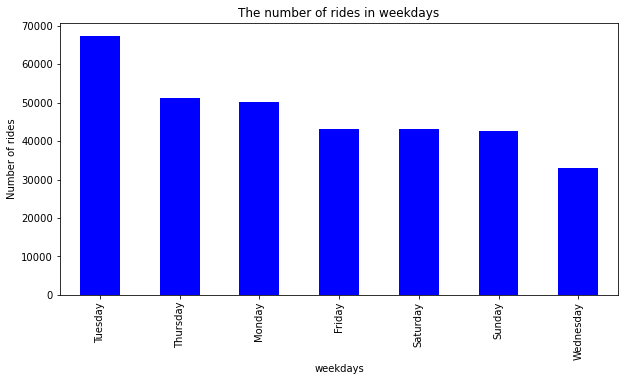

In [38]:
# display the number of rides in week days
new_sorted_uber_df['weekday'].value_counts().plot(kind='bar',figsize=(10,5),color='blue')
plt.xlabel('weekdays')
plt.ylabel('Number of rides')
plt.title('The number of rides in weekdays')
plt.savefig("Images/The number of rides in weekdays.png")

plt.show()

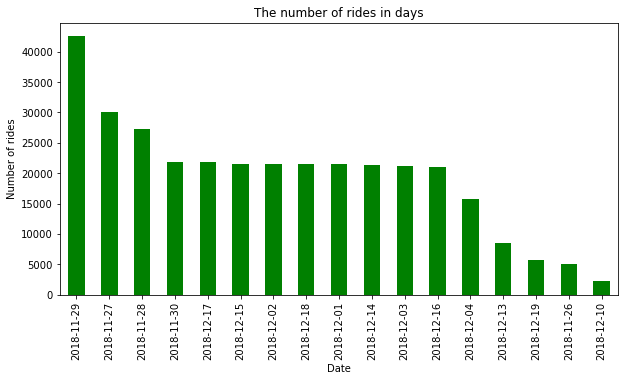

In [39]:
# number of ridays in dates
new_sorted_uber_df['date'].value_counts().plot(kind='bar',figsize=(10,5),color='green')
plt.xlabel('Date')
plt.ylabel('Number of rides')
plt.title('The number of rides in days')
plt.savefig("Images/The number of rides in date.png")

plt.show()

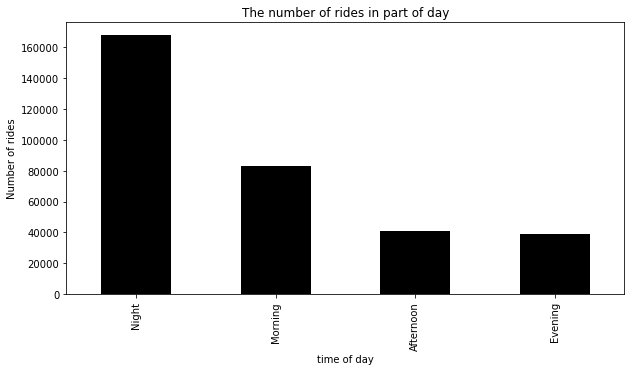

In [40]:
#number of rides in part of day
new_sorted_uber_df['time_of_day'].value_counts().plot(kind='bar',figsize=(10,5),color='black')
plt.xlabel('time of day')
plt.ylabel('Number of rides')
plt.title('The number of rides in part of day')
plt.savefig("Images/The number of rides in  part of day.png")

plt.show()

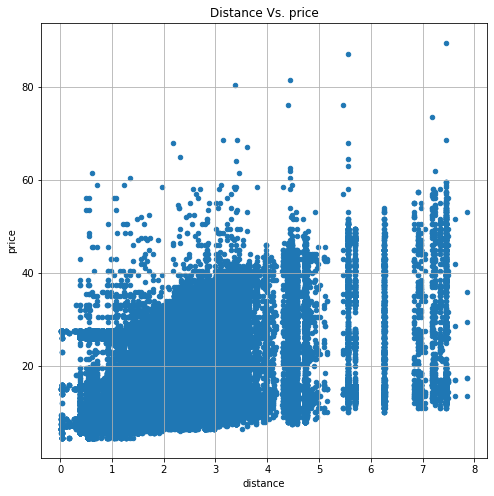

In [20]:
# Create a scatter plot which compares distance and price
new_sorted_uber_df.plot(kind="scatter", x="distance", y="price", grid=True, figsize=(8,8),
              title="Distance Vs. price")
plt.show()


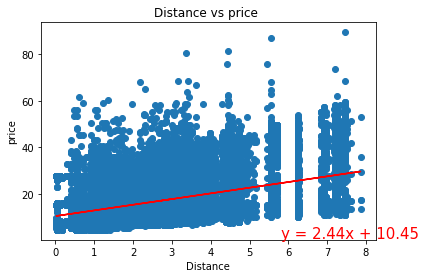

In [41]:
#linear regression 
x_values = new_sorted_uber_df['distance']
y_values = new_sorted_uber_df['price']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5.8,0.8),fontsize=15,color="red")
plt.xlabel('Distance')
plt.ylabel('price')
plt.title('Distance vs price ')
plt.savefig("Images/linear regression line.png")

plt.show()

In [22]:
# correlation between distance and price
distance = new_sorted_uber_df.iloc[:,0]
price = new_sorted_uber_df.iloc[:,4]
correlation = st.pearsonr(distance,price)
print(f"The correlation between both factors is {round(correlation[0],2)}")

The correlation between both factors is 0.34
